In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# import pytorch_wavelets as pw
from torch.nn.modules.utils import _pair, _quadruple
import pywt

In [3]:
'''
define image transforms, link two transforms together, 
1.) changes the image(color) to a tensor
2.) normalize image from range [0,1] to range [-1,1]
'''
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='.../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='.../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting .../data/cifar-10-python.tar.gz to .../data
Files already downloaded and verified


In [4]:
def imgshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    

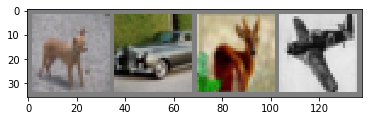

  dog   car  deer plane


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imgshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
#batchsize is 4, which is we can show images in groups of 4

In [6]:
def get_wav(in_channels,  pool=True):
    """wavelet decomposition using conv2d"""
    
    w = pywt.Wavelet('bior2.2')
    
    dec_hi = torch.Tensor(w.dec_hi[::-1]) 
    dec_lo = torch.Tensor(w.dec_lo[::-1])
    rec_hi = torch.Tensor(w.rec_hi)
    rec_lo = torch.Tensor(w.rec_lo)
    
    filter_LL = dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_LH = dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1)
    filter_HL = dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_HH = dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)
 
    if pool:
        model = nn.Conv2d
    else:
        model = nn.ConvTranspose2d

    LL = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    LH = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HL = model(in_channels, in_channels,kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HH = model(in_channels, in_channels,kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)

    LL.weight.requires_grad = False
    LH.weight.requires_grad = False
    HL.weight.requires_grad = False
    HH.weight.requires_grad = False

    LL.weight.data = filter_LL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    LH.weight.data = filter_LH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HL.weight.data = filter_HL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HH.weight.data = filter_HH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)

    return LL, LH, HL, HH

class WavePool(nn.Module):
    def __init__(self,in_channels):
        super(WavePool,self).__init__()
        self.LL,self.LH,self.HL,self.HH = get_wav(in_channels)

    def forward(self,x):
        return self.LL(x)

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [42]:
net = Net()
train_loss = []
run_loss = []
test_loss = []
test_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    test_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.708
[1,  2000] running loss: 0.316
[1,  3000] running loss: 0.197
[1,  4000] running loss: 0.141
[1,  5000] running loss: 0.108
[1,  6000] running loss: 0.089
[1,  7000] running loss: 0.075
[1,  8000] running loss: 0.064
[1,  9000] running loss: 0.056
[1, 10000] running loss: 0.048
[1, 11000] running loss: 0.043
[1, 12000] running loss: 0.040
Accuracy of the network on the 10000 test images: 51 %
Epoch 1, Training Loss:  0.542, Testing Accuracy: 0.511
[2,  1000] running loss: 0.449
[2,  2000] running loss: 0.221
[2,  3000] running loss: 0.148
[2,  4000] running loss: 0.110
[2,  5000] running loss: 0.086
[2,  6000] running loss: 0.070
[2,  7000] running loss: 0.060
[2,  8000] running loss: 0.051
[2,  9000] running loss: 0.046
[2, 10000] running loss: 0.041
[2, 11000] running loss: 0.038
[2, 12000] running loss: 0.034
Accuracy of the network on the 10000 test images: 57 %
Epoch 2, Training Loss:  0.425, Testing Accuracy: 0.573
[3,  1000] running loss: 0.376
[3,

Text(0, 0.5, 'Error')

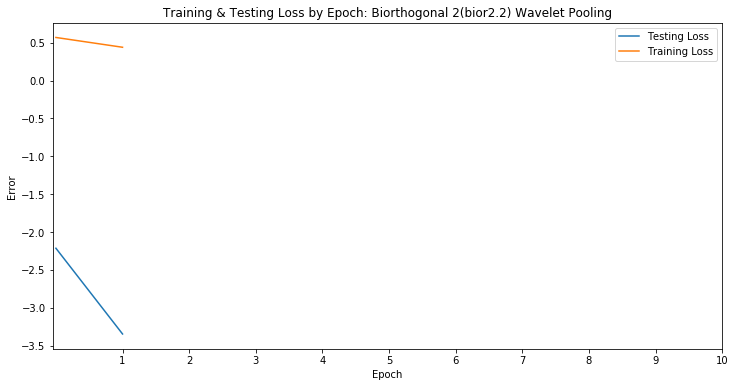

In [24]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(0,2, step=1), test_loss, label = 'Testing Loss')
plt.plot(np.arange(0, 2, step=1), train_loss, label = 'Training Loss')
plt.title('Training & Testing Loss by Epoch: Biorthogonal 2(bior2.2) Wavelet Pooling')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')